In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy import stats
from scipy.stats import qmc
from concurrent.futures import ThreadPoolExecutor
import seaborn as sns
from sympy import prevprime

In [2]:
def seed():
    np.random.seed(42)

seed()

# Q1.Implement and visualize Mandelbrot set

In [3]:
class Mandelbrot():

    def __converges(self, cs, i_list: np.array):
        i_list_sorted = np.sort(i_list)
        num_i = len(i_list_sorted)
        num_s = len(cs)

        z = np.zeros(num_s, dtype=np.complex64)
        escape_times_i_list = np.zeros((num_i, num_s), dtype=np.uint16)
        conv_i_list = np.ones((num_i, num_s), dtype=bool)

        if num_i > 1:
            i_maxs = np.zeros(num_i, dtype=np.uint16)
            i_maxs[0] = i_list_sorted[0]
            i_maxs[1:] = np.round(np.diff(i_list_sorted))
        else: 
            i_maxs = i_list_sorted

        for idx in range(num_i):
            escape_times_i_list[idx] = escape_times_i_list[idx-1] if idx > 0 else escape_times_i_list[idx]
            conv_i_list[idx] = conv_i_list[idx-1] if idx > 0 else conv_i_list[idx]
            for _ in range(i_maxs[idx]):
                z[conv_i_list[idx]] = z[conv_i_list[idx]]**2 + cs[conv_i_list[idx]]
                mask_conv = (np.abs(z) > 2)
                conv_i_list[idx, mask_conv] = False
                escape_times_i_list[idx, conv_i_list[idx]] += 1

        return conv_i_list, escape_times_i_list

    def __get_rand_dist(self, num_points):
        """Generates random complex numbers with absolute value smaller or equal to 2, i.e. sample from the circle with radius 2."""
        grid = 2 * np.sqrt(np.random.uniform(size=num_points)) * np.exp(1.j * 2 * np.pi * np.random.uniform(size=num_points))
        
        return grid.astype(np.complex64)

    def __get_rand_LHS(self, num_points): 
        """Generates random complex numbers with LHS method"""
        samples = qmc.LatinHypercube(d=2, strength=1).random(n=num_points)
        grid = 2 * np.sqrt(samples[:,0]) * np.exp(1.j * 2 * np.pi * samples[:,1])

        return grid.astype(np.complex64)
    
    def __get_rand_Orth(self, num_points): 
        """Generates random complex numbers with Orth method"""
        sampler = qmc.LatinHypercube(d=2, strength=2).random(n=num_points)
        grid = 2 * np.sqrt(sampler[:,0]) * np.exp(1.j * 2 * np.pi * sampler[:,1])

        return grid.astype(np.complex64)
    
    def get_escape_time(self, num_points, i_list: np.array):
        grid = self.__get_rand_dist(num_points)
        conv_i_list, escape_times_i_list = self.__converges(grid, i_list)

        return grid, conv_i_list, escape_times_i_list
    
    def get_escape_time_LHS(self, num_points, i_list: np.array):
        grid = self.__get_rand_LHS(num_points)
        conv_i_list, escape_times_i_list = self.__converges(grid, i_list)

        return grid, conv_i_list, escape_times_i_list
    
    def get_escape_time_Orth(self, num_points, i_list: np.array):
        grid = self.__get_rand_Orth(num_points)
        conv_i_list, escape_times_i_list = self.__converges(grid, i_list)

        return grid, conv_i_list, escape_times_i_list
    
    def get_MC(self, converges):
        MC_list = converges.sum(axis=-1) / np.size(converges, axis=-1) * np.pi * 4

        return MC_list

In [4]:
# mandelbrot = Mandelbrot()
# num_points = 100000
# max_iter = np.array([1000])
# grid, converges, escape_times = mandelbrot.get_escape_time(num_points, max_iter)
# mandelbrot.get_MC(converges)

In [5]:
def plot_Mandelbrot(grid, escape_times): 
    """
    Plot the results of the simulation with only convergence/divergence points in complex plane.
    """

    plt.figure(figsize = (6,6), dpi=300)
    plt.scatter(np.real(grid), np.imag(grid), c=np.log(escape_times), cmap='coolwarm', s=0.01)
    plt.xlim([-2,2])
    plt.ylim([-2,2])
    plt.axis('off')
    plt.show()


# Q2.Investigate the convergence

In [6]:
def get_data_rs(num_mc, i_list=None, s_list=None, save_file=None, load_file=None, num_threads=None):
    seed()

    num_i = len(i_list)
    num_s = len(s_list)

    if load_file:
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_areas_{num_mc}_random.npy', 'rb') as f:
            areas = np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_sd_{num_mc}_random.npy', 'rb') as f:
            sd = np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_upper_{num_mc}_random.npy', 'rb') as f:
            upper_ci = np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_lower_{num_mc}_random.npy', 'rb') as f:
            lower_ci = np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_converges_{num_mc}_random.npy', 'rb') as f:
            converges_i_list = np.load(f)

        return areas, sd, upper_ci, lower_ci, converges_i_list
        
    if i_list is None or s_list is None:
        raise ValueError()

    mandelbrot = Mandelbrot()
    areas = np.zeros((num_i, num_s))
    sd = np.zeros((num_i, num_s))
    upper_ci = np.zeros((num_i, num_s))
    lower_ci = np.zeros((num_i, num_s))

    max_s = np.max(s_list)
    mc_data = None
    _, converges_i_list, _ = mandelbrot.get_escape_time(max_s*num_mc, i_list)
    if save_file:
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_converges_{num_mc}_random.npy', 'wb') as f:
            np.save(f, converges_i_list)
        
    margin_tbm = stats.t.ppf(0.975, num_mc-1)/np.sqrt(num_mc)

    for s_idx, s in enumerate(s_list):
        with ThreadPoolExecutor(max_workers=num_threads) as ex:
            mc_data = list(ex.map(mandelbrot.get_MC, [converges_i_list[num, s*num:s*(num+1)] for num in np.arange(num_mc)]))

        sd[:, s_idx] = np.std(mc_data, ddof=1, axis=0)
        margin = margin_tbm*sd[:, s_idx]
        areas[:,s_idx] = np.mean(mc_data, axis=0)
        upper_ci[:,s_idx] = areas[:,s_idx] + margin
        lower_ci[:,s_idx] = areas[:,s_idx] - margin
    
    if save_file:
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_areas_{num_mc}_random.npy', 'wb') as f:
            np.save(f, areas)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_sd_{num_mc}_random.npy', 'wb') as f:
            np.save(f, sd)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_upper_{num_mc}_random.npy', 'wb') as f:
            np.save(f, upper_ci)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_lower_{num_mc}_random.npy', 'wb') as f:
            np.save(f, lower_ci)
    return areas, sd, upper_ci, lower_ci, converges_i_list

def get_data_LHS(num_mc, i_list=None, s_list=None, save_file=None, load_file=None, num_threads=None):
    seed()

    num_i = len(i_list)
    num_s = len(s_list)

    if load_file:
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_areas_{num_mc}_LHS.npy', 'rb') as f:
            areas = np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_sd_{num_mc}_LHS.npy', 'rb') as f:
            sd = np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_upper_{num_mc}_LHS.npy', 'rb') as f:
            upper_ci = np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_lower_{num_mc}_LHS.npy', 'rb') as f:
            lower_ci = np.load(f)

        return areas, sd, upper_ci, lower_ci

    if i_list is None or s_list is None:
        raise ValueError()

    mandelbrot = Mandelbrot()
    areas = np.zeros((num_i, num_s))
    sd = np.zeros((num_i, num_s))
    upper_ci = np.zeros((num_i, num_s))
    lower_ci = np.zeros((num_i, num_s))

    converges_n_i_list = None

    margin_tbm = stats.t.ppf(0.975, num_mc-1)/np.sqrt(num_mc)

    for s_idx, s in enumerate(s_list):
        with ThreadPoolExecutor(max_workers=num_threads) as ex:
            converges_n_i_list = np.array(list(ex.map(lambda i: mandelbrot.get_escape_time_LHS(s, i)[1], [i_list for _ in range(num_mc)])))

        mc_data = mandelbrot.get_MC(converges_n_i_list)

        sd[:, s_idx] = np.std(mc_data, ddof=1, axis=0)
        margin = margin_tbm*sd[:, s_idx]
        areas[:,s_idx] = np.mean(mc_data, axis=0)
        upper_ci[:,s_idx] = areas[:,s_idx] + margin
        lower_ci[:,s_idx] = areas[:,s_idx] - margin
    
    if save_file:
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_areas_{num_mc}_LHS.npy', 'wb') as f:
            np.save(f, areas)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_sd_{num_mc}_LHS.npy', 'wb') as f:
            np.save(f, sd)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_upper_{num_mc}_LHS.npy', 'wb') as f:
            np.save(f, upper_ci)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_lower_{num_mc}_LHS.npy', 'wb') as f:
            np.save(f, lower_ci)
    return areas, sd, upper_ci, lower_ci

def get_data_Orth(num_mc, i_list=None, s_list=None, save_file=None, load_file=None, num_threads=None):

    def get_prev_square_prime(n):
        return prevprime(np.sqrt(n))**2

    seed()

    num_i = len(i_list)
    num_s = len(s_list)

    if load_file:
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_areas_{num_mc}_Orth.npy', 'rb') as f:
            areas = np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_sd_{num_mc}_Orth.npy', 'rb') as f:
            sd = np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_upper_{num_mc}_Orth.npy', 'rb') as f:
            upper_ci = np.load(f)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_lower_{num_mc}_Orth.npy', 'rb') as f:
            lower_ci = np.load(f)

        return areas, sd, upper_ci, lower_ci

    if i_list is None or s_list is None:
        raise ValueError()

    mandelbrot = Mandelbrot()
    areas = np.zeros((num_i, num_s))
    sd = np.zeros((num_i, num_s))
    upper_ci = np.zeros((num_i, num_s))
    lower_ci = np.zeros((num_i, num_s))
    converges_n_i_list = None

    margin_tbm = stats.t.ppf(0.975, num_mc-1)/np.sqrt(num_mc)

    for s_idx, s in enumerate(s_list):
        prev_square_prime_s = get_prev_square_prime(s)

        with ThreadPoolExecutor(max_workers=num_threads) as ex:
            converges_n_i_list = \
                np.array(list(ex.map(lambda i: mandelbrot.get_escape_time_Orth(prev_square_prime_s, i)[1], [i_list for _ in range(num_mc)])))

        mc_data = mandelbrot.get_MC(converges_n_i_list)

        sd[:, s_idx] = np.std(mc_data, ddof=1, axis=0)
        margin = margin_tbm*sd[:, s_idx]
        areas[:,s_idx] = np.mean(mc_data, axis=0)
        upper_ci[:,s_idx] = areas[:,s_idx] + margin
        lower_ci[:,s_idx] = areas[:,s_idx] - margin
    
    if save_file:
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_areas_{num_mc}_Orth.npy', 'wb') as f:
            np.save(f, areas)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_sd_{num_mc}_Orth.npy', 'wb') as f:
            np.save(f, sd)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_upper_{num_mc}_Orth.npy', 'wb') as f:
            np.save(f, upper_ci)
        with open(f'data/vary_i_{num_i}_vary_s_{num_s}_lower_{num_mc}_Orth.npy', 'wb') as f:
            np.save(f, lower_ci)
    return areas, sd, upper_ci, lower_ci

In [7]:
def plot_heatmap(X, Y, areas, true_area, fig_filename):
    plt.figure(figsize=(9, 7))
    heatmap = plt.contourf(X, Y, np.abs(areas-true_area), cmap='RdYlGn_r', levels=20)
    plt.colorbar(heatmap, norm=LogNorm(), label='Errors in estimated area')
    plt.xscale('log')
    plt.xlabel('Number of samples', fontsize=14)
    plt.ylabel('Number of iterations', fontsize=14)
    plt.title('Errors with increasing numbers of iterations and sample sizes', fontsize=14)
    plt.grid()
    plt.tight_layout()
    plt.show()

    if fig_filename:
        plt.savefig(f'figures/{fig_filename}.png')

def plot_lineplot(x, areas, upper_ci, lower_ci, legend_title, label_vals, fig_filename=None):
    sns.set(style='whitegrid')
    plt.figure(dpi=300)
    color_list = ['r', 'b', 'orange']
    num_i, num_s = areas.shape
    if num_i < num_s:
        for i in range(num_i):
            plt.plot(x, areas[i,:], marker='o', markersize=2, color=color_list[i], label=fr'{label_vals[i]}')
            plt.fill_between(x, lower_ci[i, :], upper_ci[i, :], color=color_list[i], alpha=0.4)
    else:
        for i in range(num_s):
            plt.plot(x, areas[:,i], marker='o', markersize=2, color=color_list[i], label=fr'{label_vals[i]}')
            plt.fill_between(x, lower_ci[:,i], upper_ci[:,i], color=color_list[i], alpha=0.4)

    plt.xscale('log')
    plt.title('Area computed by uniform sampling with various i and s', fontsize=14)
    plt.xlabel('Number of samples', fontsize=12)
    plt.ylabel('estimated area', fontsize=13)
    plt.grid()
    plt.legend(title=legend_title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    if fig_filename:
        plt.savefig(f'figures/{fig_filename}.png')

Varying number of samples with fixed iterations at 100, 500 and 1000.

In [8]:
# # test
# num_i = 1
# num_s = 1
# num_mc = 1


# i_list = np.linspace(100, 1000, num_i).astype(int)
# s_list = np.array([10 ** n for n in np.linspace(2, 6, num_s)]).astype(int)
# areas_rs, sd_rs, upper_rs, lower_rs, conv_i_list_rs = get_data_rs(num_mc, i_list, s_list, save_file=True)
# areas_rs, sd_rs, upper_rs, lower_rs, conv_i_list_rs = get_data_rs(num_mc, i_list, s_list, load_file=True)

# i_idxs = [0]

# plot_lineplot(s_list_rs, areas_rs[i_idxs, :], upper_rs[i_idxs, :], lower_rs[i_idxs, :], 'Number of Iterations', i_list[i_idxs], fig_filename=f'vary_i_{num_i}_vary_s_{num_s}_{num_mc}_rs')

In [9]:
# # test
# num_i = 1
# num_s = 1
# num_mc = 2

# i_list = np.linspace(100, 1000, num_i).astype(int)
# s_list_lhs = np.array([10 ** n for n in np.linspace(2, 6, num_s)]).astype(int)
# areas_lhs, sd_lhs, upper_lhs, lower_lhs = get_data_LHS(num_mc, i_list, s_list_lhs, save_file=True)
# areas_lhs, sd_lhs, upper_lhs, lower_lhs = get_data_LHS(num_mc, i_list, s_list_lhs, load_file=True)

# i_idxs = [0]

# plot_lineplot(s_list_lhs, areas_lhs[i_idxs, :], upper_lhs[i_idxs, :], lower_lhs[i_idxs, :], 'Number of Iterations', i_list[i_idxs], fig_filename=f'vary_i_{num_i}_vary_s_{num_s}_{num_mc}_lhs')

In [10]:
# # test
# num_i = 1
# num_s = 1
# num_mc = 2

# i_list = np.linspace(100, 1000, num_i).astype(int)
# s_list_os = np.array([10 ** n for n in np.linspace(2, 6, num_s)]).astype(int)
# areas_os, sd_os, upper_os, lower_os = get_data_Orth(num_mc, i_list, s_list_os, save_file=True)
# areas_os, sd_os, upper_os, lower_os = get_data_Orth(num_mc, i_list, s_list_os, load_file=True)

# i_idxs = [0]

# plot_lineplot(s_list_os, areas_lhs[i_idxs, :], upper_lhs[i_idxs, :], lower_lhs[i_idxs, :], 'Number of Iterations', i_list[i_idxs], fig_filename=f'vary_i_{num_i}_vary_s_{num_s}_{num_mc}_os')

In [11]:
num_i = 100
num_s = 99
num_mc = 100


i_list = np.linspace(100, 1000, num_i).astype(int)
s_list_rs = np.array([10 ** n for n in np.linspace(2, 6, num_s)]).astype(int)

In [12]:
areas_rs, sd_rs, upper_rs, lower_rs, conv_i_list_rs = get_data_rs(num_mc, i_list, s_list_rs, save_file=True)

KeyboardInterrupt: 

In [ ]:
# areas_rs, sd_rs, upper_rs, lower_rs, conv_i_list_rs = get_data_rs(num_mc, i_list, s_list_rs, load_file=True)
i_500_idx = np.where(i_list == 500)[0][0]
i_idxs = [0, i_500_idx, -1]

plot_lineplot(s_list_rs, areas_rs[i_idxs, :], upper_rs[i_idxs, :], lower_rs[i_idxs, :], 'Number of Iterations', i_list[i_idxs], fig_filename=f'vary_i_{num_i}_vary_s_{num_s}_{num_mc}_rs')

In [ ]:
s_list_lhs = np.array([10 ** n for n in np.linspace(2, 6, num_s)]).astype(int)

In [ ]:
areas_lhs, sd_lhs, upper_lhs, lower_lhs = get_data_LHS(num_mc, i_list, s_list_lhs, save_file=True)

KeyboardInterrupt: 

In [ ]:
# areas_lhs, sd_lhs, upper_lhs, lower_lhs = get_data_LHS(num_mc, i_list, s_list_lhs, load_file=True)
i_500_idx = np.where(i_list == 500)[0][0]
i_idxs = [0, i_500_idx, -1]

plot_lineplot(s_list_lhs, areas_lhs[i_idxs, :], upper_lhs[i_idxs, :], lower_lhs[i_idxs, :], 'Number of Iterations', i_list[i_idxs], fig_filename=f'vary_i_{num_i}_vary_s_{num_s}_{num_mc}_lhs')

In [ ]:
s_list_os = s_list_rs[s_list_rs <= 10**4]
areas_os, sd_os, upper_os, lower_os = get_data_Orth(num_mc, i_list, s_list_os, save_file=True)

In [ ]:
# areas_os, sd_os, upper_os, lower_os = get_data_Orth(num_mc, i_list, s_list_os, save_file=True)
i_500_idx = np.where(s_list_os == 500)[0][0]
i_idxs = [0, i_500_idx, -1]

plot_lineplot(s_list_os, areas_os[i_idxs, :], upper_os[i_idxs, :], lower_os[i_idxs, :], 'Number of Iterations', i_list[i_idxs], fig_filename=f'vary_i_{num_i}_vary_s_{num_s}_{num_mc}_os')

Varying number of iterations with fixed samples size at 10^2, 10^4 and 10^6.

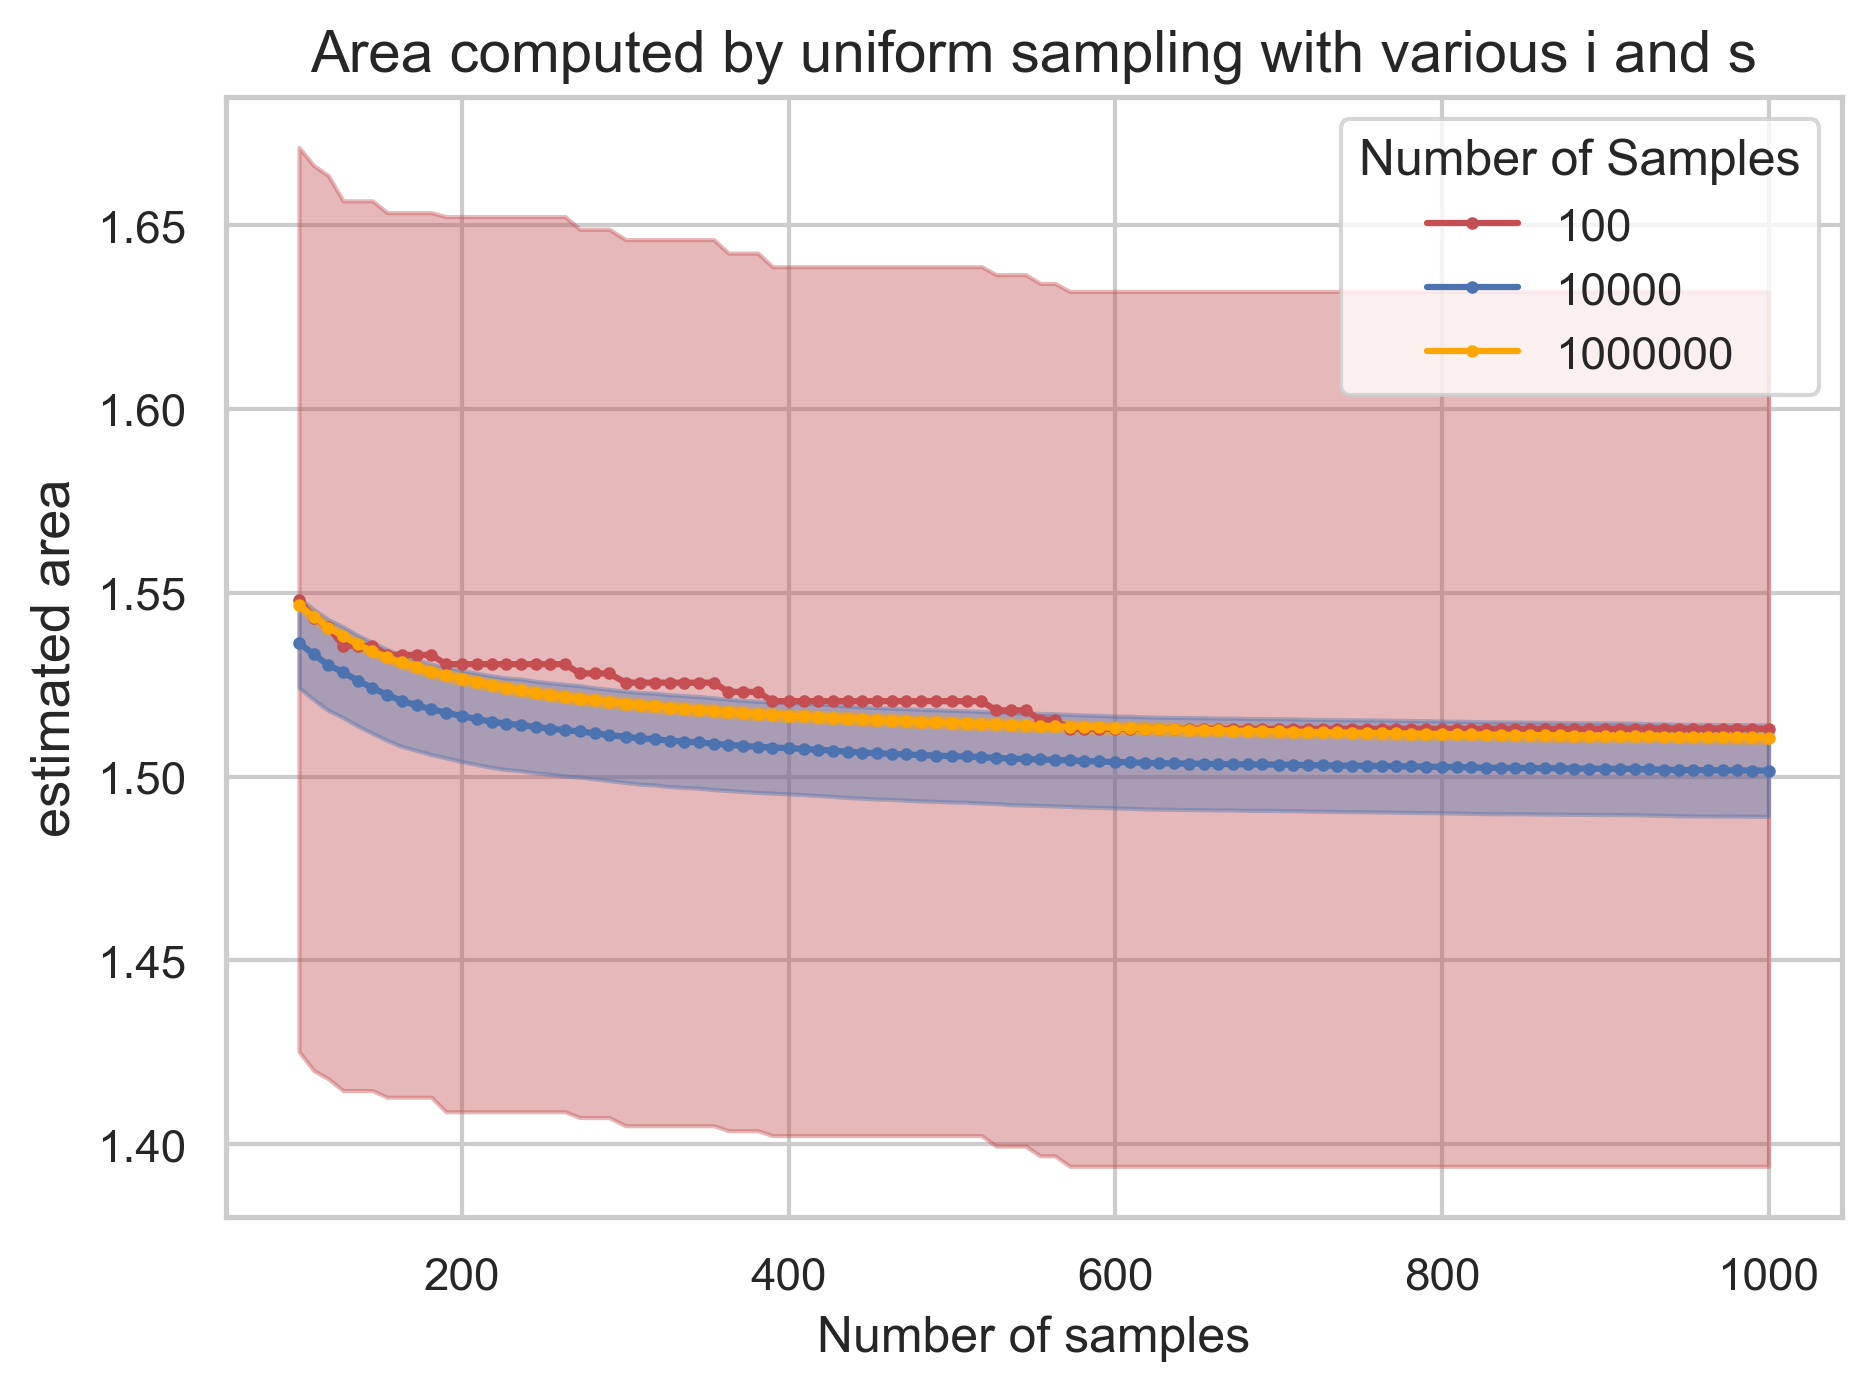

<Figure size 640x480 with 0 Axes>

In [ ]:
# areas_rs, sd_rs, upper_rs, lower_rs, conv_i_list_rs = get_data_rs(num_mc, i_list, s_list_rs, load_file=True)
s_idx_10_power_4 = np.where(s_list_rs == 10**4)[0][0]
s_idxs = [0, s_idx_10_power_4, -1]

plot_lineplot(i_list, areas_rs[:, s_idxs], upper_rs[:, s_idxs], lower_rs[:, s_idxs], 'Number of Samples', s_list_rs[s_idxs], fig_filename=f'vary_s_{num_s}_vary_i_{num_i}_{num_mc}_rs')

1.5106363354431256


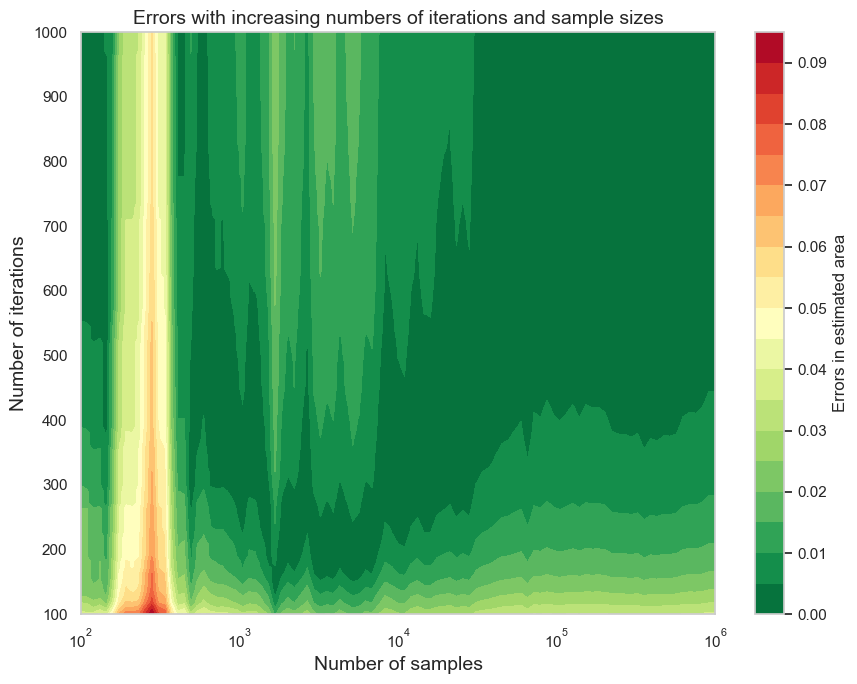

<Figure size 640x480 with 0 Axes>

In [ ]:
i_list = np.linspace(100, 1000, num_i).astype(int)
s_list = np.array([10 ** n for n in np.linspace(2, 6, num_s)]).astype(int)
true_area = areas_rs[-1, -1]
print(true_area)
X,Y = np.meshgrid(s_list, i_list)
plot_heatmap(X,Y, areas_rs, true_area, fig_filename=f'heatmap_vary_s_{num_s}_vary_i_{num_i}_{num_mc}')